In [34]:
import torch
import torchvision
import torchvision.transforms as transforms
import plotly.express as px
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import wandb

## Downloading Dataset from torchvision

In [24]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


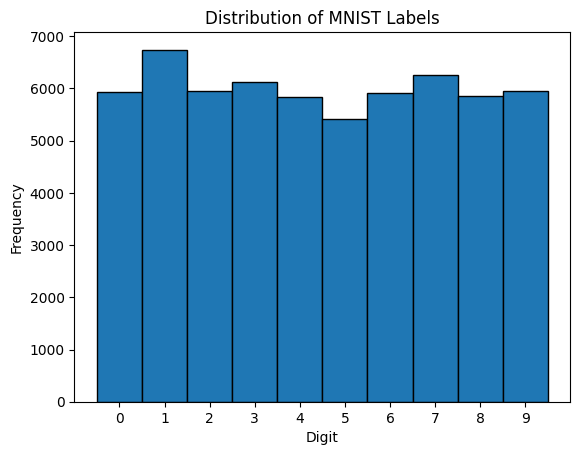

In [25]:
labels = [label for _, label in trainset]
plt.hist(labels, bins=np.arange(11) - 0.5, edgecolor='black')
plt.xticks(range(10))
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.title('Distribution of MNIST Labels')
plt.show()

In [26]:
fig = px.imshow(torchvision.utils.make_grid([trainset[i][0] for i in range(50)]).permute(1, 2, 0))
fig.show()

In [27]:
samples_per_class = 5
samples = []

for i in range(10):
    class_samples = [image for image, label in trainset if label == i][:samples_per_class]
    samples.extend(class_samples)

fig = px.imshow(torchvision.utils.make_grid(samples, nrow=samples_per_class).permute(1, 2, 0))
fig.show()

In [28]:
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

## CNN model

In [39]:
class Net(nn.Module):
    def __init__(self, kernel_size=5, stride=1, dropout=0.5, learning_rate=0.001, batch_size=4, num_epochs=10, log_to_wandb=False):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size, stride)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size, stride)
        
        # Calculate size of the feature maps after conv and pool layers
        self.feature_size = self._get_conv_output((1, 28, 28))
        
        self.fc1 = nn.Linear(self.feature_size, 500)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(500, 10)
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.stride = stride
        self.kernel_size = kernel_size
        self.log_to_wandb = log_to_wandb
        if log_to_wandb:
            self.init_wandb()

    def init_wandb(self):
        run_name = f"CNN_MNIST_kernel{self.kernel_size}_stride{self.stride}_dropout{self.dropout}_lr{self.learning_rate}_batch{self.batch_size}_epochs{self.num_epochs}"
        wandb.init(project="SMAI-Assignment-3-Part-4.3", name=run_name, config={
            "kernel_size": self.kernel_size,
            "stride": self.stride,
            "dropout": self.dropout,
            "learning_rate": self.learning_rate,
            "batch_size": self.batch_size,
            "num_epochs": self.num_epochs
        })

    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.rand(batch_size, *shape)
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    def _forward_features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(-1, self.feature_size)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


## Training Loop

In [40]:
net = Net(kernel_size=3, stride=1, dropout=0.5, learning_rate=0.001, batch_size=4, num_epochs=10)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=net.batch_size, shuffle=True)
optimizer = optim.Adam(net.parameters(), lr=net.learning_rate)

criterion = nn.CrossEntropyLoss()

for epoch in range(net.num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(trainloader)
    train_accuracy = 100. * correct_train / total_train
    
    # Validation loss
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()
    
    val_loss = val_loss / len(valloader)
    val_accuracy = 100. * correct_val / total_val
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

print('Finished Training')

Epoch 1, Train Loss: 0.1520, Train Accuracy: 95.30%, Val Loss: 0.0779, Val Accuracy: 97.48%
Epoch 2, Train Loss: 0.0725, Train Accuracy: 97.84%, Val Loss: 0.0655, Val Accuracy: 97.86%
Epoch 3, Train Loss: 0.0529, Train Accuracy: 98.35%, Val Loss: 0.0711, Val Accuracy: 98.09%
Epoch 4, Train Loss: 0.0483, Train Accuracy: 98.53%, Val Loss: 0.0612, Val Accuracy: 98.37%
Epoch 5, Train Loss: 0.0409, Train Accuracy: 98.85%, Val Loss: 0.0600, Val Accuracy: 98.34%
Epoch 6, Train Loss: 0.0430, Train Accuracy: 98.70%, Val Loss: 0.0570, Val Accuracy: 98.38%
Epoch 7, Train Loss: 0.0381, Train Accuracy: 98.92%, Val Loss: 0.0643, Val Accuracy: 98.58%
Epoch 8, Train Loss: 0.0348, Train Accuracy: 98.98%, Val Loss: 0.0743, Val Accuracy: 98.34%
Epoch 9, Train Loss: 0.0354, Train Accuracy: 99.01%, Val Loss: 0.0638, Val Accuracy: 98.38%
Epoch 10, Train Loss: 0.0316, Train Accuracy: 99.11%, Val Loss: 0.0760, Val Accuracy: 98.42%
Finished Training


In [41]:
def visualize_feature_maps(model, layer_name, image):
    model.eval()
    x = image.unsqueeze(0)
    
    activations = []
    hooks = []
    
    def hook_fn(module, input, output):
        activations.append(output)
    
    for name, layer in model.named_children():
        if isinstance(layer, (nn.Conv2d, nn.MaxPool2d)):
            hooks.append(layer.register_forward_hook(hook_fn))
    
    with torch.no_grad():
        model(x)
    
    for hook in hooks:
        hook.remove()
    
    for i, (name, layer) in enumerate(model.named_children()):
        if name == layer_name:
            activation = activations[i].squeeze(0)
            if len(activation.size()) == 3:
                fig = px.imshow(activation.permute(1, 2, 0).numpy(), facet_col=0, binary_string=True)
                fig.show()
                return
            else:
                print("Unsupported layer type for visualization")
                return
    
    print("Layer not found")

image, _ = trainset[0]
visualize_feature_maps(net, 'conv1', image)

In [43]:
wandb.login()

True

In [44]:
learning_rates = [0.01, 0.001]
batch_sizes = [4, 256]
num_epochs = 10
dropous_layers = [0.5, 0.7]
strides = [1, 2]
kernel_sizes = [3, 5]

for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for dropout in dropous_layers:
            for stride in strides:
                for kernel_size in kernel_sizes:
                    net = Net(kernel_size, stride, dropout, learning_rate, batch_size, num_epochs, log_to_wandb=True)
                    optimizer = optim.Adam(net.parameters(), lr=net.learning_rate)
                    criterion = nn.CrossEntropyLoss()
                    for epoch in range(net.num_epochs):
                        running_loss = 0.0
                        correct_train = 0
                        total_train = 0
                        for i, data in enumerate(trainloader, 0):
                            inputs, labels = data
                            optimizer.zero_grad()
                            outputs = net(inputs)
                            loss = criterion(outputs, labels)
                            loss.backward()
                            optimizer.step()
                            running_loss += loss.item()
                            _, predicted = outputs.max(1)
                            total_train += labels.size(0)
                            correct_train += predicted.eq(labels).sum().item()
                        
                        train_loss = running_loss / len(trainloader)
                        train_accuracy = 100. * correct_train / total_train
                        
                        # Validation loss
                        val_loss = 0.0
                        correct_val = 0
                        total_val = 0
                        with torch.no_grad():
                            for data in valloader:
                                images, labels = data
                                outputs = net(images)
                                loss = criterion(outputs, labels)
                                val_loss += loss.item()
                                _, predicted = outputs.max(1)
                                total_val += labels.size(0)
                                correct_val += predicted.eq(labels).sum().item()
                        
                        val_loss = val_loss / len(valloader)
                        val_accuracy = 100. * correct_val / total_val

                        if net.log_to_wandb:
                            wandb.log({
                                "Train Loss": train_loss,
                                "Train Accuracy": train_accuracy,
                                "Validation Loss": val_loss,
                                "Validation Accuracy": val_accuracy
                            })
                            
                        else:
                            print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train Accuracy,█▂▆▅▇▁▅▁▄▃
Train Loss,█▆▄▁▄▄▆▇▄▅
Validation Accuracy,▁█▄█▃▃▂▄█▃
Validation Loss,▅▂▂▆█▁▂▂█▄
Train Accuracy,10.54583
Train Loss,2.30496
Validation Accuracy,10.04167
Validation Loss,2.30638


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train Accuracy,▄█▇▇▅▆▄▃▂▁
Train Loss,▄▁▃▃▆▄▇▇▇█
Validation Accuracy,▇▇▇█▆▇▄▇▅▁
Validation Loss,▁▂▁▁▂▁▃▂▂█
Train Accuracy,69.71042
Train Loss,1.03023
Validation Accuracy,62.65833
Validation Loss,1.55252


RuntimeError: Given input size: (20x1x1). Calculated output size: (20x0x0). Output size is too small